In [1]:
# COLAB ONLY STUFF
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import random

class DataLoader():
    def __init__(self, filepath):
        cwd = os.getcwd()
        self.basepath = filepath
        try:
            os.stat(self.basepath+"/add_prim_split")
            os.stat(self.basepath+"/few_shot_split")
            os.stat(self.basepath+"/filler_split")
            os.stat(self.basepath+"/length_split")
            os.stat(self.basepath+"/simple_split")
            os.stat(self.basepath+"/template_split")
        except Exception as e:
            raise Exception("Path "+filepath+" doesnt seem to contain the required folders.")

    def load_1a(self):
        train = self.file_loader("/simple_split/tasks_train_simple.txt")
        test = self.file_loader("/simple_split/tasks_test_simple.txt")

        return (np.asarray(train), np.asarray(test))

    def load_1b(self):
        percentile_dict = {}
        splits = ["1", "2", "4", "8", "16", "32", "64"]

        for percentile in splits:
            train = self.file_loader("/simple_split/size_variations/tasks_train_simple_p{}.txt".format(percentile))
            test = self.file_loader("/simple_split/size_variations/tasks_test_simple_p{}.txt".format(percentile))
            
            percentile_dict[percentile] = (np.asarray(train), np.asarray(test))
            
        return percentile_dict

    def load_2(self):
        train = self.file_loader("/length_split/tasks_train_length.txt")
        test = self.file_loader("/length_split/tasks_test_length.txt")

        return (np.asarray(train), np.asarray(test))

    def load_3(self):
        """
        loads the datasets for both parts of the experiment
        the first part where both primitives appear without compositional commands
        the second part where 'jump' primitive appears in
        compositional commands of varying lengths
        returns a dictionary of pairs all possible train/test sets
        """
        data_dict = {}
        nums = ["1", "2", "4", "8", "16", "32"]
        reps = ["1", "2", "3", "4", "5"]

        train = self.file_loader("/add_prim_split/tasks_train_addprim_jump.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_jump.txt")
        data_dict['jump'] = (np.asarray(train), np.asarray(test))

        train = self.file_loader("/add_prim_split/tasks_train_addprim_turn_left.txt")
        test = self.file_loader("/add_prim_split/tasks_test_addprim_turn_left.txt")
        data_dict['lturn'] = (np.asarray(train), np.asarray(test))
        
        for num in nums:
            for rep in reps:
                train = self.file_loader("/add_prim_split/with_additional_examples/tasks_train_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                test = self.file_loader("/add_prim_split/with_additional_examples/tasks_test_addprim_complex_jump_num{}_rep{}.txt".format(num, rep))
                
                data_dict['jump_num{}_rep{}'.format(num, rep)] = (np.asarray(train), np.asarray(test))
            
        return data_dict

    def file_loader(self, path):
        sent_list = []
        with open(self.basepath+path, "r") as f:
                    for line in f:
                        sent_list.append(line_splitter(line))
        return sent_list

    
def line_splitter(sentence):
    sent_list = sentence.split("OUT: ")
    sent_list[0] = sent_list[0].strip("IN: ")
    sent_list[1] = sent_list[1].strip("\n")

    return sent_list

# examples:
# 1a :
#   train, test = dl.load_1a()
#   train[0][0] first train sentence, "IN"
#   train[0][1] first train sentence, "OUT"
# 1b :
#   dict = dl.load_1b()
#   train, test = dict["1"] extract the 1 percentile sentences out, split into train and test
#   train[0][0] first train sentence, "OUT"
#   train[0][1] first train sentence, "OUT"
#
# all returns are numpy arrays


In [0]:
#from data_loader import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SOS_token = 0
EOS_token = 1

class Input:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


class Output:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

        
def get_embedding(word, lookup_dict, embeds):
    tensor = torch.tensor([lookup_dict[word]], dtype=torch.long)
    return embeds(tensor)


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    output_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, output_tensor)

In [0]:
#from data_loader import *
#from embeddings import *

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.0, layers=1, mode='RNN'):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        self.mode = mode
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)

        if self.mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)
        elif self.mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        output, hidden = self.hidden_layer(output, hidden)
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.0, layers=1, attention=False, mode='RNN'):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        self.layers = layers
        self.max_length = max_length
        self.attention = attention
        self.mode = mode

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        if self.attention:
	        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
	        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        self.hidden_layer = nn.RNN(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)

        if self.mode == 'LSTM':
        	self.hidden_layer = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)
        elif self.mode == 'GRU':
        	self.hidden_layer = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.layers, dropout=self.dropout_p)
        
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs=None):
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)

        if self.attention:
          if self.mode=="LSTM":
            attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0][0]), 1)), dim=1)   
          else:
            attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0]), 1)), dim=1)   
          attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))
          output = torch.cat((output[0], attn_applied[0]), 1)
          output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.hidden_layer(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.layers, 1, self.hidden_size, device=device)
        nn.init.xavier_uniform_(hidden, gain=nn.init.calculate_gain('relu'))
        return hidden

def train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length, clipping_value=5):
    encoder_hidden1 = encoder.initHidden()
    encoder_hidden2 = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    output_length = output_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        if encoder.mode == 'LSTM':
            encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei], (encoder_hidden1, encoder_hidden2))
        else: 
            encoder_output, encoder_hidden1 = encoder(input_tensor[ei], encoder_hidden1)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden1 = encoder_hidden1
    decoder_hidden2 = encoder_hidden2

    forcing = random.random() > 0.5

    if forcing:
        for di in range(output_length):
            if decoder.mode == 'LSTM':
              decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
              decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            
            decoder_input = output_tensor[di]
            loss += criterion(decoder_output, output_tensor[di])

            if decoder_input.item() == EOS_token:
              break
    else:
        for di in range(output_length):
            if decoder.mode == 'LSTM':
              decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
            else:
              decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, output_tensor[di])
            
            if decoder_input.item() == EOS_token:
              break

    loss.backward()

    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clipping_value)
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clipping_value)

    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / output_length

    
def trainIters(encoder, decoder, train_data, input_lang, output_lang, max_length, learning_rate=0.001):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    losses = []
    print(train_data.shape[0])
    print_loss_total = 0

    for iter in range(train_data.shape[0]):
        training_pair = tensorsFromPair(train_data[iter], input_lang, output_lang)
        input_tensor = training_pair[0]
        output_tensor = training_pair[1]

        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
            output_tensor = output_tensor.cuda()
        
        loss = train(input_tensor, output_tensor, encoder, encoder_optimizer, decoder, decoder_optimizer, criterion, max_length)
        print_loss_total += loss

        if iter % 1000 == 0:
            print_loss_avg = print_loss_total / 500
            losses.append(print_loss_avg)
            print(iter)
            print(print_loss_avg)
            print_loss_total = 0

    return losses

In [0]:
def train_and_save(train_data, train_in, train_out, model, dropout, att, layers, model_name, file_prefix, hidden_units=200, MAX_LENGTH=100):
    encoder = Encoder(train_in.n_words, hidden_units, layers=layers, mode=model, dropout_p=dropout)
    decoder = Decoder(hidden_units, train_out.n_words, layers=layers, max_length=MAX_LENGTH, mode=model, dropout_p=dropout, attention=att)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

    losses = trainIters(encoder, decoder, train_data, train_in, train_out, MAX_LENGTH)
    plt.plot(losses)
    plt.title(model+'_layers='+str(layers)+'_drop='+str(dropout)+'_attention='+str(att))
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()
    torch.save(encoder.state_dict(), file_prefix+model_name+"_encoder.pt")
    torch.save(decoder.state_dict(), file_prefix+model_name+"_decoder.pt")

def load_models(train_in_nwords, train_out_nwords, hidden_size, layers, mode, dropout_p, attention, file_location, model_name, max_length=100):
    encoder = Encoder(train_in_nwords, hidden_size, layers=layers, mode=mode, dropout_p=dropout_p)
    encoder.load_state_dict(torch.load(file_location+model_name+"_encoder.pt"))
    encoder.eval()

    decoder = Decoder(hidden_size, train_out_nwords, max_length, layers=layers, mode=mode, dropout_p=dropout_p, attention=attention)
    decoder.load_state_dict(torch.load(file_location+model_name+"_decoder.pt"))
    decoder.eval()

    return encoder, decoder

In [0]:
#from data_loader import *
#from embeddings import *
#from layers_attempt import *

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(encoder, decoder, sentence, train_in, train_out, max_length=100):
  with torch.no_grad():
    input_tensor = tensorFromSentence(train_in, sentence)
    if torch.cuda.is_available():
      input_tensor = input_tensor.cuda()
      encoder.cuda()
      decoder.cuda()

    input_length = input_tensor.size()[0]
    encoder_hidden1 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)
    encoder_hidden2 = torch.zeros(encoder.layers, 1, encoder.hidden_size, device=device)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
      if encoder.mode == "LSTM":
        encoder_output, (encoder_hidden1, encoder_hidden2) = encoder(input_tensor[ei],(encoder_hidden1, encoder_hidden2))
      else:
        encoder_output, encoder_hidden1 = encoder(input_tensor[ei], encoder_hidden1)
      encoder_outputs[ei] += encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden1 = encoder_hidden1
    decoder_hidden2 = encoder_hidden2

    decoded_words = []
    
    for di in range(max_length):
      if decoder.mode == "LSTM":
        decoder_output, (decoder_hidden1, decoder_hidden2) = decoder(decoder_input, (decoder_hidden1, decoder_hidden2), encoder_outputs)
      else:
        decoder_output, decoder_hidden1 = decoder(decoder_input, decoder_hidden1, encoder_outputs)
      
      topv, topi = decoder_output.data.topk(1) 
      
      if topi.item() == EOS_token:
        break
      else:
        decoded_words.append(train_out.index2word[topi.item()])
      
      decoder_input = topi.squeeze().detach()

    return decoded_words

def evaluateIters(test_data, encoder, decoder, train_in, train_out):
    hit = 0
    miss = 0
    iters = 0
    hit_idx = []
    miss_idx = []

    for idx, test_point in enumerate(test_data):
        pred_list = evaluate(encoder, decoder, test_point[0], train_in, train_out)
        pred = " ".join(pred_list)
        if pred == test_point[1]:
            hit += 1
            hit_idx.append(idx)
        else:
            miss += 1
            miss_idx.append(idx)
        iters += 1

        if iters % 100 == 0:
            print(iters)
            print(hit)

    return hit, hit_idx, miss, miss_idx

def evaluate_and_save(test_data, model_name, save_file, encoder, decoder, train_in, train_out):
    print(encoder.hidden_size)
    hit, hit_idx, miss, miss_idx = evaluateIters(test_data, encoder, decoder, train_in, train_out)
    acc = 1-miss/len(test_data)

    with open("/content/drive/My Drive/Colab Notebooks/models/"+save_file, 'a') as f:
        f.write("Model name: " + model_name + "\n")
        f.write("Hits: " + str(hit) + "\n")
        f.write("Miss: " + str(miss) + "\n")
        f.write("Accuracy: " + str(acc) + "\n")


In [0]:
import matplotlib.pyplot as plt

#USED IN COLAB
dl = DataLoader("/content/drive/My Drive/Colab Notebooks/SCAN")

#USED ON OWN PC
#dl = DataLoader("SCAN")

#MAX_LENGTH = max([len(x[0].split()) for x in train_data]) + 1
MAX_LENGTH = 100

#DATA LOADING AND LANGUAGE CREATION, DIFFERS BETWEEN EXERCISES
_, test_data = dl.load_2()

test_in = Input("test_input")
test_out = Output("test_output")

for datapoint in test_data:
        test_in.addSentence(datapoint[0])
        test_out.addSentence(datapoint[1])

plt.rcParams['figure.figsize'] = [10, 6]

In [8]:
from os import path
print(path.exists("/content/drive/My Drive/Colab Notebooks/models/"))

True


100000
0
0.004147333526611329
1000
2.6785910911880695
2000
1.7166558382885686
3000
1.2240471660286063
4000
1.005243717809581
5000
0.8188051326930014
6000
0.7099622021674286
7000
0.6133371809163967
8000
0.5236726616478136
9000
0.39341044186867524
10000
0.3989638828327031
11000
0.29152751207908234
12000
0.27174735421777385
13000
0.2371609142997526
14000
0.21964153190646082
15000
0.20974840496395894
16000
0.19152547280235044
17000
0.17395064722901352
18000
0.10727524805269587
19000
0.12074514029496297
20000
0.11454199922322111
21000
0.1235444507799222
22000
0.10843405634463324
23000
0.0873169976049494
24000
0.11313246876265676
25000
0.0742612423882863
26000
0.1060049674292137
27000
0.08194089375508157
28000
0.05771988084140221
29000
0.05395078534254109
30000
0.05044805006637531
31000
0.047840785453457886
32000
0.0724914185103695
33000
0.05274599319702638
34000
0.04484800092529565
35000
0.0622410100200937
36000
0.03732803378269198
37000
0.07004939073036286
38000
0.03729015445730104
39000
0

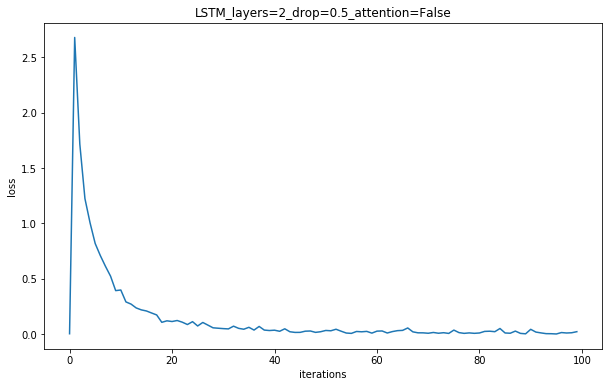

200
100
91
200
184
300
275
400
344
500
406
600
464
700
515
800
561
900
561
1000
561
1100
561
1200
561
1300
561
1400
561
1500
561
1600
561
1700
561
1800
561
1900
561
2000
561
2100
561
2200
561
2300
561
2400
561
2500
561
2600
561
2700
561
2800
561
2900
561
3000
561
3100
561
3200
561
3300
561
3400
561
3500
561
3600
561
3700
561
3800
561
3900
561
################### ITERATION 1 DONE ###################


In [10]:
file_location = "/content/drive/My Drive/Colab Notebooks/models/"
hidden_units=200
model='LSTM'
model_name = "2nd_LSTM_200_dim_2_layer_no_att_drop"

for i in range(1, 2):

    train_data, _ = dl.load_2()

    train_in = Input("train_input")
    train_out = Output("train_output")

    for datapoint in train_data:
        train_in.addSentence(datapoint[0])
        train_out.addSentence(datapoint[1])

    train_data = train_data[np.random.choice(train_data.shape[0], 100000, replace=True), :]

    train_and_save(train_data, train_in, train_out, model, 0.5, False, 2, model_name+str(i), file_location, hidden_units=hidden_units)
    encoder, decoder = load_models(train_in.n_words, train_out.n_words, hidden_units, 2, model, 0.5, False, file_location, model_name+str(i))
    evaluate_and_save(test_data, model_name+str(i), model_name+str(i)+".txt", encoder, decoder, train_in, train_out)
    print("################### ITERATION " +str(i) +" DONE ###################")

In [0]:
#LOADING THE MODELS
#encoder, decoder = load_models(train_in.n_words, train_out.n_words, hidden_units, 2, "GRU", 0.5, True, file_location, "example")

In [0]:
train_data, _ = dl.load_2()

train_in = Input("train_input")
train_out = Output("train_output")

for datapoint in train_data:
    train_in.addSentence(datapoint[0])
    train_out.addSentence(datapoint[1])

file_location = "/content/drive/My Drive/Colab Notebooks/models/"
hidden_units=200
model='LSTM'
model_name = "2nd_LSTM_200_dim_2_layer_att_no_drop"


encoder, decoder = load_models(train_in.n_words, train_out.n_words, hidden_units, 2, model, 0.5, False, file_location, model_name)


In [0]:
#EVALUATION OF MODEL
actual_train_data, test_data = dl.load_2()
hit, hit_idx, miss, miss_idx = evaluateIters(test_data, encoder, decoder, train_in, train_out)

In [0]:
#ACCURACY
acc=1-miss/test_data.shape[0]
print(acc)

In [0]:
#SOME RANDOM PRINTING/EVALUATION VALIDATION
idx = miss_idx[2]
print(test_data[idx][0])
print(len(evaluate(encoder, decoder, test_data[idx][0], train_in, train_out)))
print(" ".join(evaluate(encoder, decoder, test_data[idx][0], train_in, train_out)))
print(len(test_data[idx][1].split()))
print(test_data[idx][1])